## Main code

------------- DataSet info ------------
Training data:  139
Validation data:  20
Visualize some Validation data:


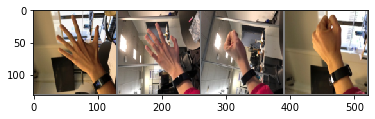

tensor([1, 1, 0, 0])
------------ Start Training -----------
Final loss: 0.8216489155311137
------ Finished Training ------
------ Start Validating ------


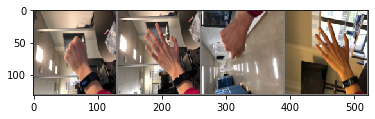

tensor([0, 1, 0, 0], device='cuda:0')


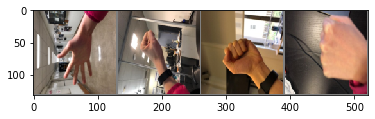

tensor([1, 1, 0, 0], device='cuda:0')


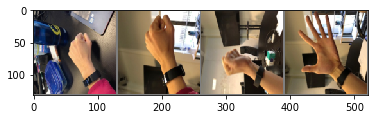

tensor([0, 0, 0, 1], device='cuda:0')


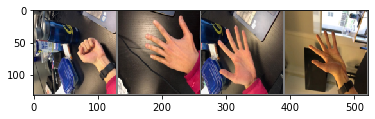

tensor([0, 1, 0, 1], device='cuda:0')


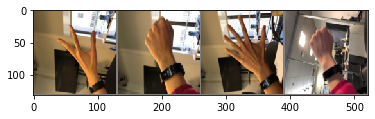

tensor([1, 0, 1, 1], device='cuda:0')
Accuracy of the network on the 10000 test images: 80 %


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import tarfile

# Define NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29* 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Function
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


## Load data
size = 128
data_transforms = {
    'train': transforms.Compose(
            [transforms.Resize([size, size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])]),
    'val': transforms.Compose(
            [transforms.Resize([size, size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])])
}

filename = "data_set.tar.xz"
data_dir = './data_set'
tf = tarfile.open(filename)
tf.extractall(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

## Print dataSet info
print("------------- DataSet info ------------")
print("Training data: ",dataset_sizes['train'])
print("Validation data: ",dataset_sizes['val'])
# visualize sampled data
print("Visualize some Validation data:")
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(labels)

## Setup NN training
# initialize NN
net = Net()
# setup loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Detect CUDA
if torch.cuda.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

## Train NN
print('------------ Start Training -----------')
for epoch in range(10):  # loop over the dataset multiple times
#    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

print("Final loss:",running_loss)
print('------ Finished Training ------')

## Save Net
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Validate with validation data
print('------ Start Validating ------')
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        #images, labels = data
        images, labels = data[0], data[1].to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
        print(predicted)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

